# 第十章：异常值检测

daitu

学习使用Python Outlier Detection (PyOD)库挑选出垃圾邮件（可以认为是正常邮件数据中的异常值）

https://github.com/yzhao062/Pyod

In [1]:
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
## 图像在jupyter notebook中显示
%matplotlib inline
## 显示的图片格式（mac中的高清格式），还可以设置为"bmp"等格式
%config InlineBackend.figure_format = "retina"
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer,TfidfTransformer
from sklearn import metrics
## 加载异常值检测库
from pyod import models


## 垃圾邮件分类


https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

SMS Spam Collection Data Set 

In [2]:
## 读取邮件数据
spam = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/SMSSpamCollection",sep="\t",header=None)
spam.columns = ["classification","text"]
spam.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
pd.value_counts(spam.classification)

ham     4825
spam     747
Name: classification, dtype: int64

可以发现垃圾邮件数据只占全部数据集的13%，可以认为垃圾邮件数据是一种异常值。

In [4]:
# 将类别转化为数字,使用0代表正常的邮件，1代表垃圾邮件（异常值）
spam["label"] = spam.classification.map({'ham':0, 'spam':1})
spam.head()

,classification,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### 绘制两种类型邮件的词云

观察两种类型的邮件的关键词差别

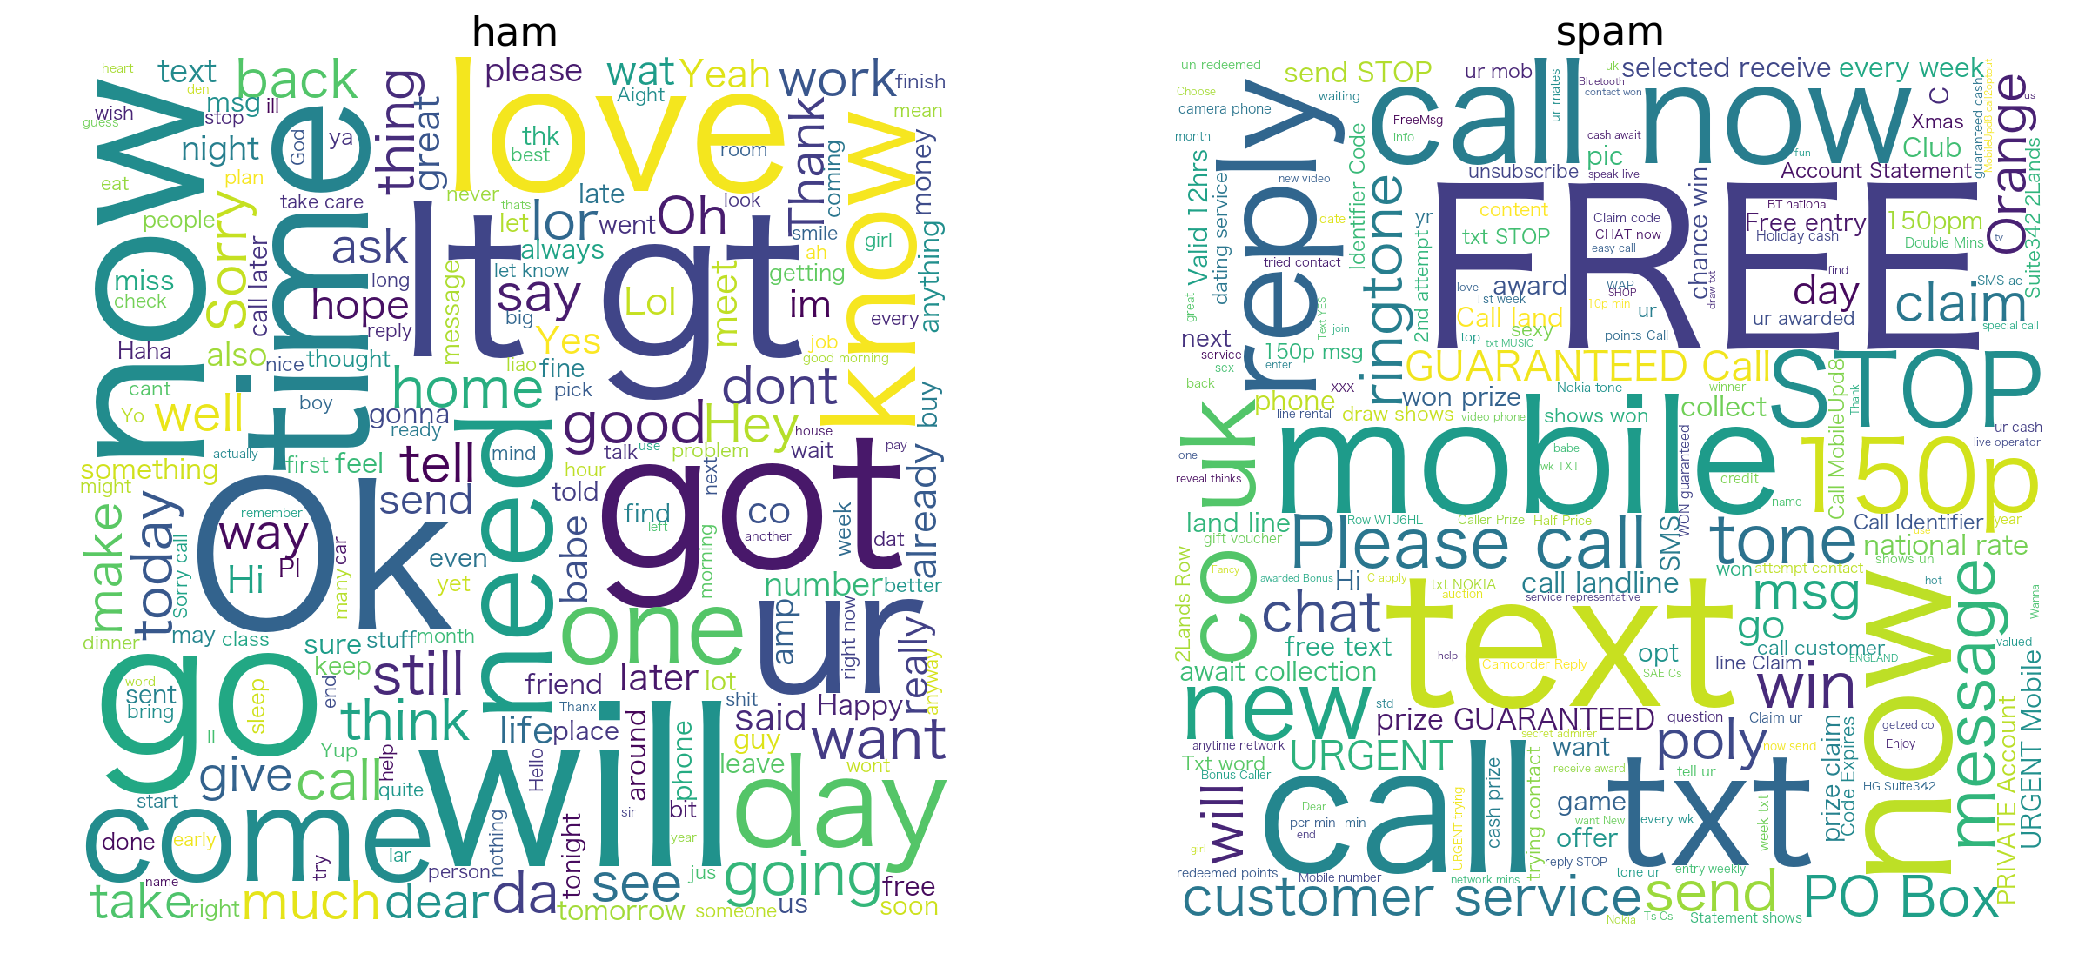

In [5]:
classification = ["ham","spam"]
plt.figure(figsize=(18,8))
for ii,cla in enumerate(classification):
    text = spam.text[spam.classification == cla]
    ## 设置词云参数
    WordC = WordCloud(font_path="/Library/Fonts/Hiragino Sans GB W3.ttc",
                        margin=1,width=1000, height=1000,
                        max_words=200, min_font_size=5, 
                        background_color='white',
                        max_font_size=250,)
    WordC.generate_from_text(" ".join(text))
    plt.subplot(1,2,ii+1)
    plt.imshow(WordC)
    plt.title(cla,size = 20)
    plt.axis("off")
plt.show()    

### 训练模型
为了验证使用异常值检测的方法是有效的，将数据集，切分为训练集和验证集

数据集花粉后，需要对数据集特征进行提取，使用文本的TF－IDF用于异常值检测

In [10]:
## 切分数据集
train_x,test_x,train_y,test_y = train_test_split(spam.text,spam.label,test_size = 0.25, random_state=0)

In [11]:
pd.value_counts(train_y)
pd.value_counts(test_y)

0    1208
1     185
Name: label, dtype: int64

In [12]:
## 数据预处理,将英文根据空格将数据切分，统计词频TF，计算TFIDF
vectorizer = CountVectorizer(stop_words="english")    
transformer = TfidfTransformer()
train_tfidf = transformer.fit_transform(vectorizer.fit_transform(train_x))
## 特征转化为array数组
train_tfidf = train_tfidf.toarray()
train_tfidf.shape

(4179, 7287)

In [13]:
test_tfidf = transformer.transform(vectorizer.transform(test_x))
test_tfidf = test_tfidf.toarray()
test_tfidf.shape

(1393, 7287)

**可以发现训练集和测试集均有7287个特征**

In [14]:
## 加载异常值检测库
from pyod import models

## 1:使用线性模型进行异常值检测
Linear Models for Outlier Detection

PCA: Principal Component Analysis（主成分分析）


In [15]:
# PCA: Principal Component Analysis（主成分分析）
pcaod = models.pca.PCA(n_selected_components = 100, # 用于计算异常值得分的主成分个数
                       contamination = 0.135 ,## 数据异常值比例，default＝0.1
                       random_state = 123)
## 对训练集进行训练
pcaod.fit(train_tfidf)

PCA(contamination=0.135, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=100, random_state=123, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [16]:
## 输出解释方差百分比
sum(pcaod.explained_variance_ratio_[0:100])

0.13404015458098534

In [12]:
## 对测试集进行测试，找到异常值
## 0 stands for inliers and 1 for outliers.
pcaod_pre = pcaod.predict(test_tfidf)
## 计算找到的异常值（垃圾邮件）和真实标记的混淆矩阵
metrics.confusion_matrix(test_y,pcaod_pre)

array([[1086,  122],
       [ 125,   60]])

In [13]:
print(metrics.classification_report(test_y,pcaod_pre))

             precision    recall  f1-score   support

          0       0.90      0.90      0.90      1208
          1       0.33      0.32      0.33       185

avg / total       0.82      0.82      0.82      1393



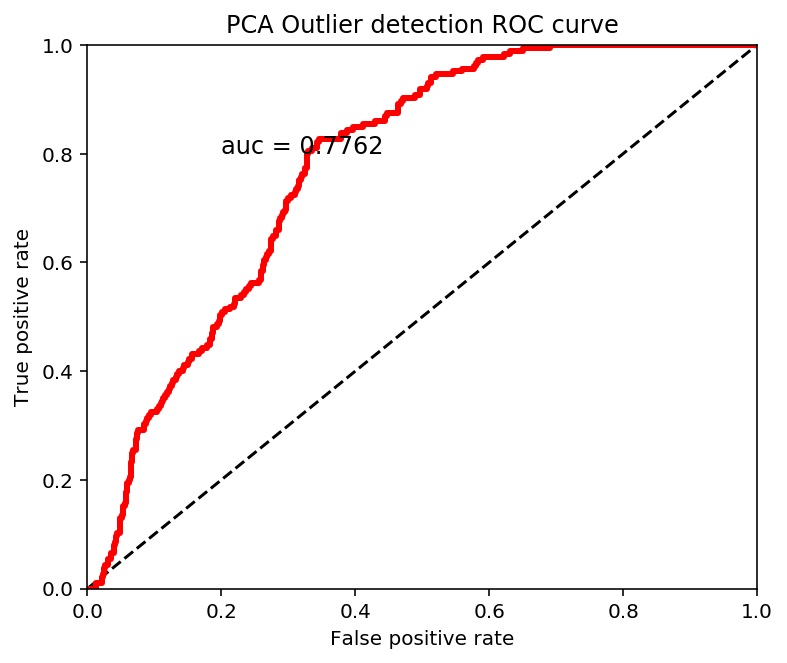

In [14]:
## plot ROC曲线
pre_y = pcaod.predict_proba(test_tfidf)[:, 1]
fpr_Nb, tpr_Nb, _ = metrics.roc_curve(test_y, pre_y)
auc = metrics.auc(fpr_Nb, tpr_Nb)
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('PCA Outlier detection ROC curve')
plt.text(0.2,0.8,"auc = "+str(round(auc,4)),fontsize=12)
plt.show()

## 2: 基于组合模型的异常值检测

Isolation Forest

In [17]:
## IsolationForest异常值检测器
ifood = models.iforest.IForest(n_estimators = 5000,  ## The number of base estimators in the ensemble.
                               max_samples = 1000,
                               contamination = 0.135 ,## 数据异常值比例，default＝0.1
                               max_features = 500,
                               n_jobs  = 4,
                               random_state = 123)
## 对训练集进行训练
ifood.fit(train_tfidf)

IForest(bootstrap=False, contamination=0.135, max_features=500,
    max_samples=1000, n_estimators=5000, n_jobs=4, random_state=123,
    verbose=0)

In [18]:
## 对测试集进行测试，找到异常值
## 0 stands for inliers and 1 for outliers.
ifood_pre = ifood.predict(test_tfidf)
## 计算找到的异常值（垃圾邮件）和真实标记的混淆矩阵
metrics.confusion_matrix(test_y,ifood_pre)

array([[1166,   42],
       [  76,  109]])

In [19]:
print(metrics.classification_report(test_y,ifood_pre))

             precision    recall  f1-score   support

          0       0.94      0.97      0.95      1208
          1       0.72      0.59      0.65       185

avg / total       0.91      0.92      0.91      1393



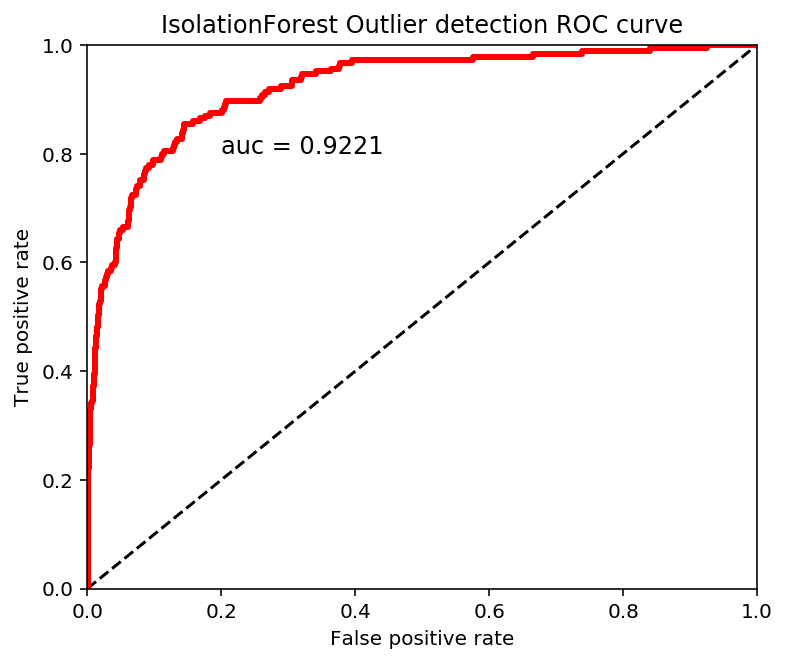

In [20]:
## plot ROC曲线
pre_y = ifood.predict_proba(test_tfidf)[:, 1]
fpr_Nb, tpr_Nb, _ = metrics.roc_curve(test_y, pre_y)
auc = metrics.auc(fpr_Nb, tpr_Nb)
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('IsolationForest Outlier detection ROC curve')
plt.text(0.2,0.8,"auc = "+str(round(auc,4)),fontsize=12)
plt.show()

**IsolationForest 异常值检测器的检测准确率达到92%**